In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/breast-cancer-allen-new/Breast Cancer Detection - combined_data.csv
/kaggle/input/breast-cancer-allen-new/data_combined/idc_067.jpg
/kaggle/input/breast-cancer-allen-new/data_combined/ilc_071.jpg
/kaggle/input/breast-cancer-allen-new/data_combined/tnbc_025.jpg
/kaggle/input/breast-cancer-allen-new/data_combined/tnbc_075.jpg
/kaggle/input/breast-cancer-allen-new/data_combined/ilc_109.jpg
/kaggle/input/breast-cancer-allen-new/data_combined/tnbc_077.jpg
/kaggle/input/breast-cancer-allen-new/data_combined/mbc_090.jpg
/kaggle/input/breast-cancer-allen-new/data_combined/idc_091.jpg
/kaggle/input/breast-cancer-allen-new/data_combined/ilc_057.jpg
/kaggle/input/breast-cancer-allen-new/data_combined/mbc_121.jpg
/kaggle/input/breast-cancer-allen-new/data_combined/tnbc_107.jpg
/kaggle/input/breast-cancer-allen-new/data_combined/tnbc_045.jpg
/kaggle/input/breast-cancer-allen-new/data_combined/tnbc_015.jpg
/kaggle/input/breast-cancer-allen-new/data_combined/tnbc_063.jpg
/kaggle/input/b

In [4]:
import pandas as pd
csv_path = "/kaggle/input/breast-cancer-allen-new/Breast Cancer Detection - combined_data.csv"
df = pd.read_csv(csv_path)


In [5]:
df = df.drop(columns=['location'])
df = df[df['intensity'].notnull() & df['staining'].notnull()]
df['subtype'] = df['subtype'].replace({'lLC': 'ILC'})


                   image_path subtype biomarker intensity staining
0  data_combined/tnbc_001.jpg    TNBC     Ki-67  Moderate   Medium
1  data_combined/tnbc_002.jpg    TNBC     Ki-67    Strong     High
2  data_combined/tnbc_003.jpg    TNBC     Ki-67    Strong     High
3  data_combined/tnbc_004.jpg    TNBC     Ki-67    Strong     High
4  data_combined/tnbc_005.jpg    TNBC     Ki-67    Strong   Medium
<class 'pandas.core.frame.DataFrame'>
Index: 600 entries, 0 to 600
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  600 non-null    object
 1   subtype     600 non-null    object
 2   biomarker   600 non-null    object
 3   intensity   600 non-null    object
 4   staining    600 non-null    object
dtypes: object(5)
memory usage: 28.1+ KB
None
image_path    0
subtype       0
biomarker     0
intensity     0
staining      0
dtype: int64
['TNBC' 'IDC' 'MBC' 'ILC']
subtype
TNBC    151
IDC     150
MBC     150
ILC     1

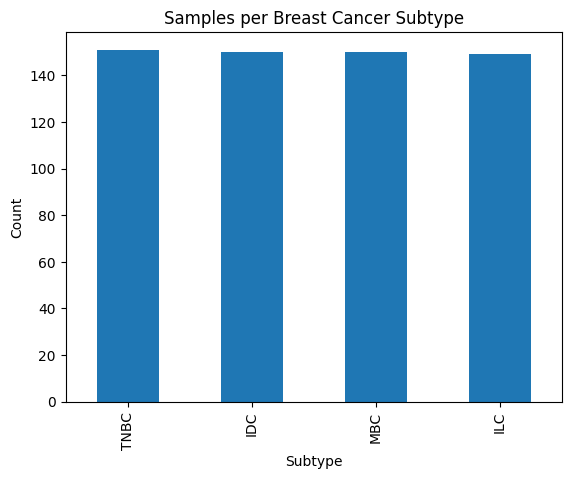

In [7]:
print(df.head())
print(df.info())
print(df.isnull().sum())
print(df['subtype'].unique())
print(df['subtype'].value_counts())
biomarker_cols = ['biomarker', 'intensity', 'staining']
for col in biomarker_cols:
    print(df[col].value_counts())
import matplotlib.pyplot as plt
df['subtype'].value_counts().plot(kind='bar')
plt.title('Samples per Breast Cancer Subtype')
plt.xlabel('Subtype')
plt.ylabel('Count')
plt.show()


In [32]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm

In [33]:
df = pd.read_csv("/kaggle/input/breast-cancer-allen-new/Breast Cancer Detection - combined_data.csv")
df = df.drop(columns=['location'])
df = df[df['intensity'].notnull() & df['staining'].notnull()]
df['subtype'] = df['subtype'].replace({'lLC': 'ILC'})
df['image_path'] = df['image_path'].replace('data_combined/idc_061.jpg', 'data_combined/idc_61.jpg')

min_class = df['subtype'].value_counts().min()
test_per_class = min(30, min_class // 5)
df_test = df.groupby('subtype').sample(n=test_per_class, random_state=42)
df_train = df.drop(df_test.index)

In [34]:
biomarker_cols = ['biomarker', 'intensity', 'staining']
bio_dummies = pd.get_dummies(df[biomarker_cols])
bio_features = bio_dummies.columns
df_train_bio = pd.get_dummies(df_train[biomarker_cols]).reindex(columns=bio_features, fill_value=0).astype(np.float32)
df_test_bio = pd.get_dummies(df_test[biomarker_cols]).reindex(columns=bio_features, fill_value=0).astype(np.float32)


In [39]:
class BreastDataset(Dataset):
    def __init__(self, df, biomarker_feats, img_size=224):
        self.df = df.reset_index(drop=True)
        self.img_size = img_size
        self.transforms = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
        ])
        self.biomarker_feats = torch.tensor(np.array(biomarker_feats), dtype=torch.float32)
        self.subtype_map = {k: v for v, k in enumerate(sorted(df['subtype'].unique()))}
        self.labels = df['subtype'].map(self.subtype_map).values
        self.img_paths = "/kaggle/input/breast-cancer-allen-new/"+df['image_path'].values
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        x_img = Image.open(self.img_paths[idx]).convert('RGB')
        x_img = self.transforms(x_img)
        x_bio = self.biomarker_feats[idx]
        y = self.labels[idx]
        return x_img, x_bio, y

In [40]:

train_ds = BreastDataset(df_train, df_train_bio)
test_ds = BreastDataset(df_test, df_test_bio)
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = DataLoader(test_ds, batch_size=16, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = len(df['subtype'].unique())
bio_dim = train_ds.biomarker_feats.shape[1]


In [41]:
class FusionNet(nn.Module):
    def __init__(self, num_classes, bio_dim):
        super().__init__()
        self.cnn = models.resnet18(pretrained=True)
        self.cnn.fc = nn.Identity()
        self.bio_proj = nn.Linear(bio_dim, 128)
        self.head = nn.Linear(512 + 128, num_classes)
    def forward(self, img, bio):
        x1 = self.cnn(img)
        x2 = self.bio_proj(bio)
        x = torch.cat([x1, x2], dim=1)
        return self.head(x)

model = FusionNet(num_classes, bio_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [42]:

for epoch in range(1, 21):
    model.train()
    total, correct, running_loss = 0, 0, 0.0
    for x_img, x_bio, y in tqdm(train_dl, desc=f"Epoch {epoch} [Train]"):
        x_img, x_bio, y = x_img.to(device), x_bio.to(device), y.to(device)
        out = model(x_img, x_bio)
        loss = loss_fn(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pred = out.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
        running_loss += loss.item() * y.size(0)
    train_acc = correct / total
    train_loss = running_loss / total

    model.eval()
    val_total, val_correct, val_loss = 0, 0, 0.0
    with torch.no_grad():
        for x_img, x_bio, y in tqdm(val_dl, desc=f"Epoch {epoch} [Val]"):
            x_img, x_bio, y = x_img.to(device), x_bio.to(device), y.to(device)
            out = model(x_img, x_bio)
            loss = loss_fn(out, y)
            pred = out.argmax(1)
            val_correct += (pred == y).sum().item()
            val_total += y.size(0)
            val_loss += loss.item() * y.size(0)
    val_acc = val_correct / val_total
    val_loss = val_loss / val_total

    print(f"Epoch {epoch}: train_acc={train_acc:.4f}, train_loss={train_loss:.4f}, val_acc={val_acc:.4f}, val_loss={val_loss:.4f}")

Epoch 1 [Val]: 100%|██████████| 8/8 [00:12<00:00,  1.58s/it]


Epoch 1: train_acc=0.3595, train_loss=1.3601, val_acc=0.3621, val_loss=1.3755


Epoch 2 [Val]: 100%|██████████| 8/8 [00:11<00:00,  1.43s/it]


Epoch 2: train_acc=0.6488, train_loss=0.8575, val_acc=0.3793, val_loss=1.3117


Epoch 3 [Val]: 100%|██████████| 8/8 [00:11<00:00,  1.43s/it]


Epoch 3: train_acc=0.7583, train_loss=0.6515, val_acc=0.3448, val_loss=1.5219


Epoch 4 [Val]: 100%|██████████| 8/8 [00:11<00:00,  1.42s/it]


Epoch 4: train_acc=0.7583, train_loss=0.5946, val_acc=0.4310, val_loss=1.7757


Epoch 5 [Val]: 100%|██████████| 8/8 [00:11<00:00,  1.42s/it]


Epoch 5: train_acc=0.7996, train_loss=0.5166, val_acc=0.3707, val_loss=1.8485


Epoch 6 [Val]: 100%|██████████| 8/8 [00:10<00:00,  1.30s/it]


Epoch 6: train_acc=0.7789, train_loss=0.5062, val_acc=0.3966, val_loss=1.6558


Epoch 7 [Val]: 100%|██████████| 8/8 [00:11<00:00,  1.42s/it]


Epoch 7: train_acc=0.7872, train_loss=0.4603, val_acc=0.4138, val_loss=1.9118


Epoch 8 [Val]: 100%|██████████| 8/8 [00:11<00:00,  1.41s/it]


Epoch 8: train_acc=0.8058, train_loss=0.4027, val_acc=0.4224, val_loss=2.2868


Epoch 9 [Val]: 100%|██████████| 8/8 [00:11<00:00,  1.40s/it]


Epoch 9: train_acc=0.7955, train_loss=0.4135, val_acc=0.3966, val_loss=1.9247


Epoch 10 [Val]: 100%|██████████| 8/8 [00:11<00:00,  1.38s/it]


Epoch 10: train_acc=0.8161, train_loss=0.3957, val_acc=0.4052, val_loss=2.2540


Epoch 11 [Val]: 100%|██████████| 8/8 [00:11<00:00,  1.38s/it]


Epoch 11: train_acc=0.8244, train_loss=0.3656, val_acc=0.4138, val_loss=2.1978


Epoch 12 [Val]: 100%|██████████| 8/8 [00:10<00:00,  1.26s/it]


Epoch 12: train_acc=0.8368, train_loss=0.3405, val_acc=0.4397, val_loss=2.1960


Epoch 13 [Val]: 100%|██████████| 8/8 [00:11<00:00,  1.38s/it]


Epoch 13: train_acc=0.8326, train_loss=0.3310, val_acc=0.4569, val_loss=2.1788


Epoch 14 [Val]: 100%|██████████| 8/8 [00:11<00:00,  1.39s/it]


Epoch 14: train_acc=0.8202, train_loss=0.3538, val_acc=0.4052, val_loss=2.0034


Epoch 15 [Val]: 100%|██████████| 8/8 [00:11<00:00,  1.41s/it]


Epoch 15: train_acc=0.8037, train_loss=0.3096, val_acc=0.4224, val_loss=2.2048


Epoch 16 [Val]: 100%|██████████| 8/8 [00:11<00:00,  1.47s/it]


Epoch 16: train_acc=0.8244, train_loss=0.3431, val_acc=0.4310, val_loss=2.4316


Epoch 17 [Val]: 100%|██████████| 8/8 [00:12<00:00,  1.52s/it]


Epoch 17: train_acc=0.8306, train_loss=0.3087, val_acc=0.4224, val_loss=2.3986


Epoch 18 [Val]:  12%|█▎        | 1/8 [00:02<00:19,  2.84s/it]


KeyboardInterrupt: 

In [43]:
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from PIL import Image
from transformers import ViTModel, ViTFeatureExtractor
from tqdm import tqdm

2025-06-26 13:10:50.812170: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750943451.350826      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750943451.475590      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [44]:
data_path = "/kaggle/input/breast-cancer-allen-new/Breast Cancer Detection - combined_data.csv"
df2 = pd.read_csv(data_path)
df2 = df2.drop(columns=['location'])
df2 = df2[df2['intensity'].notnull() & df2['staining'].notnull()]
df2['subtype'] = df2['subtype'].replace({'lLC': 'ILC'})
df2['image_path'] = df2['image_path'].replace('data_combined/idc_061.jpg', 'data_combined/idc_61.jpg')

min_count = df2['subtype'].value_counts().min()
val_n = min(30, min_count // 5)
df2_val = df2.groupby('subtype').sample(n=val_n, random_state=42)
df2_train = df2.drop(df2_val.index)

In [45]:
bio_cols = ['biomarker', 'intensity', 'staining']
bio2_dummies = pd.get_dummies(df2[bio_cols])
bio2_features = bio2_dummies.columns
df2_train_bio = pd.get_dummies(df2_train[bio_cols]).reindex(columns=bio2_features, fill_value=0).astype(np.float32)
df2_val_bio = pd.get_dummies(df2_val[bio_cols]).reindex(columns=bio2_features, fill_value=0).astype(np.float32)


In [46]:
vit_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [47]:
class CancerViTDataset(Dataset):
    def __init__(self, df, bio_feats):
        self.df = df.reset_index(drop=True)
        self.img_paths = "/kaggle/input/breast-cancer-allen-new/"+df['image_path'].values
        self.bio_feats = torch.tensor(np.array(bio_feats), dtype=torch.float32)
        self.label_map = {k: v for v, k in enumerate(sorted(df['subtype'].unique()))}
        self.labels = df['subtype'].map(self.label_map).values
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        img = Image.open(self.img_paths[idx]).convert('RGB')
        img = vit_extractor(images=img, return_tensors="pt")['pixel_values'][0]
        bio = self.bio_feats[idx]
        y = self.labels[idx]
        return img, bio, y

In [48]:
trainset2 = CancerViTDataset(df2_train, df2_train_bio)
valset2 = CancerViTDataset(df2_val, df2_val_bio)
trainloader2 = DataLoader(trainset2, batch_size=16, shuffle=True)
valloader2 = DataLoader(valset2, batch_size=16, shuffle=False)


In [49]:

device2 = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_classes2 = len(df2['subtype'].unique())
bio2_dim = trainset2.bio_feats.shape[1]

In [50]:
class ViTFusionNet(nn.Module):
    def __init__(self, n_cls, bio_dim):
        super().__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224')
        self.bio_head = nn.Linear(bio_dim, 128)
        self.classifier = nn.Linear(self.vit.config.hidden_size + 128, n_cls)
    def forward(self, img, bio):
        x1 = self.vit(img).pooler_output
        x2 = self.bio_head(bio)
        x = torch.cat([x1, x2], dim=1)
        return self.classifier(x)

In [51]:

model2 = ViTFusionNet(n_classes2, bio2_dim).to(device2)
opt2 = torch.optim.AdamW(model2.parameters(), lr=2e-5)
loss2 = nn.CrossEntropyLoss()


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [52]:
for ep in range(1, 21):
    model2.train()
    n, corr, loss_sum = 0, 0, 0.0
    for xi, xb, y in tqdm(trainloader2, desc=f"Ep {ep} [Train]"):
        xi, xb, y = xi.to(device2), xb.to(device2), y.to(device2)
        out = model2(xi, xb)
        l = loss2(out, y)
        opt2.zero_grad()
        l.backward()
        opt2.step()
        pred = out.argmax(1)
        corr += (pred == y).sum().item()
        n += y.size(0)
        loss_sum += l.item() * y.size(0)
    acc_tr = corr / n
    loss_tr = loss_sum / n

    model2.eval()
    vn, vcorr, vloss_sum = 0, 0, 0.0
    with torch.no_grad():
        for xi, xb, y in tqdm(valloader2, desc=f"Ep {ep} [Val]"):
            xi, xb, y = xi.to(device2), xb.to(device2), y.to(device2)
            out = model2(xi, xb)
            l = loss2(out, y)
            pred = out.argmax(1)
            vcorr += (pred == y).sum().item()
            vn += y.size(0)
            vloss_sum += l.item() * y.size(0)
    acc_val = vcorr / vn
    loss_val = vloss_sum / vn

    print(f"Ep {ep}: train_acc={acc_tr:.4f}, train_loss={loss_tr:.4f}, val_acc={acc_val:.4f}, val_loss={loss_val:.4f}")

Ep 1 [Val]: 100%|██████████| 8/8 [00:24<00:00,  3.05s/it]


Ep 1: train_acc=0.2831, train_loss=1.3809, val_acc=0.3707, val_loss=1.3162


Ep 2 [Val]: 100%|██████████| 8/8 [00:24<00:00,  3.04s/it]


Ep 2: train_acc=0.5041, train_loss=1.1748, val_acc=0.3362, val_loss=1.2962


Ep 3 [Val]: 100%|██████████| 8/8 [00:24<00:00,  3.05s/it]


Ep 3: train_acc=0.6260, train_loss=0.9806, val_acc=0.3103, val_loss=1.3345


Ep 4 [Val]: 100%|██████████| 8/8 [00:24<00:00,  3.04s/it]


Ep 4: train_acc=0.6880, train_loss=0.8420, val_acc=0.4310, val_loss=1.2996


Ep 5 [Val]: 100%|██████████| 8/8 [00:24<00:00,  3.04s/it]


Ep 5: train_acc=0.7707, train_loss=0.6503, val_acc=0.4052, val_loss=1.3686


Ep 6 [Val]: 100%|██████████| 8/8 [00:24<00:00,  3.04s/it]


Ep 6: train_acc=0.8058, train_loss=0.5224, val_acc=0.3879, val_loss=1.4993


Ep 7 [Val]: 100%|██████████| 8/8 [00:24<00:00,  3.04s/it]


Ep 7: train_acc=0.8140, train_loss=0.4728, val_acc=0.3534, val_loss=1.6471


Ep 8 [Val]: 100%|██████████| 8/8 [00:23<00:00,  2.98s/it]


Ep 8: train_acc=0.8182, train_loss=0.4072, val_acc=0.3534, val_loss=1.7235


Ep 9 [Val]: 100%|██████████| 8/8 [00:24<00:00,  3.07s/it]


Ep 9: train_acc=0.8058, train_loss=0.3965, val_acc=0.3448, val_loss=1.7498


Ep 10 [Val]: 100%|██████████| 8/8 [00:24<00:00,  3.05s/it]


Ep 10: train_acc=0.8140, train_loss=0.3767, val_acc=0.3362, val_loss=1.9495


Ep 11 [Val]: 100%|██████████| 8/8 [00:24<00:00,  3.03s/it]


Ep 11: train_acc=0.8079, train_loss=0.3362, val_acc=0.3621, val_loss=1.9173


Ep 12 [Val]: 100%|██████████| 8/8 [00:24<00:00,  3.04s/it]


Ep 12: train_acc=0.8223, train_loss=0.3217, val_acc=0.3621, val_loss=1.9617


Ep 13 [Val]: 100%|██████████| 8/8 [00:24<00:00,  3.05s/it]


Ep 13: train_acc=0.8037, train_loss=0.3099, val_acc=0.3966, val_loss=1.9834


Ep 14 [Val]: 100%|██████████| 8/8 [00:24<00:00,  3.07s/it]


Ep 14: train_acc=0.8058, train_loss=0.2974, val_acc=0.3793, val_loss=2.0124


Ep 15 [Val]: 100%|██████████| 8/8 [00:24<00:00,  3.03s/it]


Ep 15: train_acc=0.7975, train_loss=0.2934, val_acc=0.4138, val_loss=2.0375


Ep 16 [Val]: 100%|██████████| 8/8 [00:24<00:00,  3.05s/it]


Ep 16: train_acc=0.8079, train_loss=0.2933, val_acc=0.3707, val_loss=2.0956


Ep 17 [Val]: 100%|██████████| 8/8 [00:24<00:00,  3.05s/it]


Ep 17: train_acc=0.8079, train_loss=0.2761, val_acc=0.3879, val_loss=2.0845


Ep 18 [Train]:  55%|█████▍    | 17/31 [01:06<00:54,  3.93s/it]


KeyboardInterrupt: 

In [66]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from PIL import Image
from transformers import AutoImageProcessor, AutoModel
from torchvision import transforms
from tqdm import tqdm

In [72]:
df_img = pd.read_csv("/kaggle/input/breast-cancer-allen-new/Breast Cancer Detection - combined_data.csv")
df_img = df_img.drop(columns=['location'])
df_img = df_img[df_img['intensity'].notnull() & df_img['staining'].notnull()]
df_img['subtype'] = df_img['subtype'].replace({'lLC': 'ILC'})
df_img['image_path'] = df_img['image_path'].replace('data_combined/idc_061.jpg', 'data_combined/idc_61.jpg')

minc = df_img['subtype'].value_counts().min()
test_num = min(30, minc // 5)
df_valimg = df_img.groupby('subtype').sample(n=test_num, random_state=42)
df_trainimg = df_img.drop(df_valimg.index)

bm_cols = ['biomarker', 'intensity', 'staining']
bm_dummy_all = pd.get_dummies(df_img[bm_cols])
bm_feat_cols = bm_dummy_all.columns
df_trainimg_bio = pd.get_dummies(df_trainimg[bm_cols]).reindex(columns=bm_feat_cols, fill_value=0).astype(np.float32)
df_valimg_bio = pd.get_dummies(df_valimg[bm_cols]).reindex(columns=bm_feat_cols, fill_value=0).astype(np.float32)


In [73]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
transform_dino = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize,
])

class DinoTMASet(Dataset):
    def __init__(self, df, bm_feats):
        self.df = df.reset_index(drop=True)
        self.img_paths = "/kaggle/input/breast-cancer-allen-new/" + df['image_path'].values
        self.bm_feats = torch.tensor(np.array(bm_feats), dtype=torch.float32)
        self.lbl_map = {k: v for v, k in enumerate(sorted(df['subtype'].unique()))}
        self.labels = df['subtype'].map(self.lbl_map).values
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        img = Image.open(self.img_paths[idx]).convert('RGB')
        img = transform_dino(img)
        bio = self.bm_feats[idx]
        y = self.labels[idx]
        return img, bio, y


In [74]:
tr_dset = DinoTMASet(df_trainimg, df_trainimg_bio)
va_dset = DinoTMASet(df_valimg, df_valimg_bio)
tr_loader = DataLoader(tr_dset, batch_size=16, shuffle=True)
va_loader = DataLoader(va_dset, batch_size=16, shuffle=False)

dev_dino = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_cls_dino = len(df_img['subtype'].unique())
bio_dim_dino = tr_dset.bm_feats.shape[1]


In [75]:

class DinoMLPFusion(nn.Module):
    def __init__(self, num_classes, bio_dim):
        super().__init__()
        self.backbone = AutoModel.from_pretrained("1aurent/vit_small_patch16_256.tcga_brca_dino")
        for param in self.backbone.parameters():
            param.requires_grad = False
        vit_out_dim = 384
        self.bio_proj = nn.Linear(bio_dim, 128)
        self.head = nn.Sequential(
            nn.Linear(vit_out_dim + 128, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    def forward(self, img, bio):
        with torch.no_grad():
            x_img = self.backbone(img).pooler_output
        x_bio = self.bio_proj(bio)
        x = torch.cat([x_img, x_bio], dim=1)
        return self.head(x)

dino_model = DinoMLPFusion(num_cls_dino, bio_dim_dino).to(dev_dino)
dino_opt = torch.optim.AdamW(dino_model.head.parameters(), lr=1e-4)
dino_loss = nn.CrossEntropyLoss()

In [77]:
for ep in range(1, 6):
    dino_model.train()
    n, corr, loss_sum = 0, 0, 0.0
    for xi, xb, y in tqdm(tr_loader, desc=f"Ep {ep} [Train]"):
        xi, xb, y = xi.to(dev_dino), xb.to(dev_dino), y.to(dev_dino)
        out = dino_model(xi, xb)
        l = dino_loss(out, y)
        dino_opt.zero_grad()
        l.backward()
        dino_opt.step()
        pred = out.argmax(1)
        corr += (pred == y).sum().item()
        n += y.size(0)
        loss_sum += l.item() * y.size(0)
    acc_tr = corr / n
    loss_tr = loss_sum / n

    dino_model.eval()
    vn, vcorr, vloss_sum = 0, 0, 0.0
    with torch.no_grad():
        for xi, xb, y in tqdm(va_loader, desc=f"Ep {ep} [Val]"):
            xi, xb, y = xi.to(dev_dino), xb.to(dev_dino), y.to(dev_dino)
            out = dino_model(xi, xb)
            l = dino_loss(out, y)
            pred = out.argmax(1)
            vcorr += (pred == y).sum().item()
            vn += y.size(0)
            vloss_sum += l.item() * y.size(0)
    acc_val = vcorr / vn
    loss_val = vloss_sum / vn

    print(f"Ep {ep+10}: train_acc={acc_tr:.4f}, train_loss={loss_tr:.4f}, val_acc={acc_val:.4f}, val_loss={loss_val:.4f}")

Ep 1 [Val]: 100%|██████████| 8/8 [00:11<00:00,  1.39s/it]


Ep 11: train_acc=0.6860, train_loss=0.7941, val_acc=0.6121, val_loss=0.9113


Ep 2 [Val]: 100%|██████████| 8/8 [00:11<00:00,  1.39s/it]


Ep 12: train_acc=0.7025, train_loss=0.7773, val_acc=0.6379, val_loss=0.8955


Ep 3 [Val]: 100%|██████████| 8/8 [00:11<00:00,  1.39s/it]


Ep 13: train_acc=0.7293, train_loss=0.7484, val_acc=0.6638, val_loss=0.8731


Ep 4 [Val]: 100%|██████████| 8/8 [00:11<00:00,  1.40s/it]


Ep 14: train_acc=0.7190, train_loss=0.7488, val_acc=0.6897, val_loss=0.8696


Ep 5 [Val]: 100%|██████████| 8/8 [00:11<00:00,  1.40s/it]

Ep 15: train_acc=0.7169, train_loss=0.7337, val_acc=0.6724, val_loss=0.8478


In [78]:
torch.save(dino_model.state_dict(), "dino_model.pth")


In [79]:
# Load the model
model_loaded = DinoMLPFusion(num_cls_dino, bio_dim_dino).to(dev_dino)
model_loaded.load_state_dict(torch.load("dino_model.pth", map_location=dev_dino))
model_loaded.eval()

# Validation/test loop
vn, vcorr, vloss_sum = 0, 0, 0.0
with torch.no_grad():
    for xi, xb, y in tqdm(va_loader, desc="Ep [Loaded Model Val]"):
        xi, xb, y = xi.to(dev_dino), xb.to(dev_dino), y.to(dev_dino)
        out = model_loaded(xi, xb)
        l = dino_loss(out, y)
        pred = out.argmax(1)
        vcorr += (pred == y).sum().item()
        vn += y.size(0)
        vloss_sum += l.item() * y.size(0)
acc_val = vcorr / vn
loss_val = vloss_sum / vn
print(f"Loaded model - val_acc={acc_val:.4f}, val_loss={loss_val:.4f}")


Ep [Loaded Model Val]: 100%|██████████| 8/8 [00:11<00:00,  1.42s/it]

Loaded model - val_acc=0.6724, val_loss=0.8478
